In [1]:
# Function to take a folder path, load the behavioral and licking data. Clean it to a nice lil pandas df
def load_beh_data(path, animal_id):

    import os 
    import pandas as pd
    import numpy as np

    file_pandas = animal_id + "_df.csv"
    if os.path.isfile(file_pandas):
        beh_df = pd.read_csv(file_pandas)
    else:
    
        file_data = 'analyze_animal_'+animal_id+'.mat'
        data_path = os.path.join(path,file_data)

        beh_data = import_matlab_file(data_path)
        beh_df, ignore = pd_from_uneven_dict(beh_data['animal'])
        beh_df = beh_df.rename(columns={"lick_0": "RH", "lick_1": "LH", "lick_2": "RM", "lick_3": "LM", "lick_4": "NG"})

        boo_cols = ["RH", "LH", "RM", "LM", "NG", "LED"]
        beh_df[boo_cols] = beh_df[boo_cols].astype(bool)


        # file_ttl = 'ttl_info_'+animal_id+'.mat'
        # ttl_path = os.path.join(path, file_ttl)
        # ttl_data = import_matlab_file(ttl_path)

        # beh_df['Spout_1']= np.mean(ttl_data['trial_info']['lick'][:,750:825,0],axis = 1)
        # beh_df['Spout_2'] = np.mean(ttl_data['trial_info']['lick'][:,750:825,1],axis = 1)


        file_ttl2 = 'ttl_choices_'+animal_id+'.mat'
        ttl_path2 = os.path.join(path, file_ttl2)
        ttl_data2 = import_matlab_file(ttl_path2)
        c = ttl_data2['trial_info']['choice'][:,:,750:1750]
        beh_df['latency'] = determine_latency(beh_df['rxnTime'], c)

        beh_df.to_csv(file_pandas, index= False)
        

    return beh_df

In [2]:
# Function that infers the latency of a response from the lick rasters
def determine_latency(rxn, c):
    import numpy as np
    rx = []
    for a in range(c.shape[0]):
        r = (np.argwhere(c[a,:,:]== 1))

        if r.size == 0 and rxn[a] > 0:
            rx.append(rxn[a]);
        elif r.size == 0:
            rx.append(np.nan)
            #ch.append(np.nan)
        else:
            #ch.append(r[0][0])
            rx.append(r[0][1])

    return rx

In [3]:
def import_matlab_file(file):
    from scipy.io import loadmat
    
    mat_data = loadmat(file, struct_as_record = False, squeeze_me = True, mat_dtype = True, chars_as_strings = True, simplify_cells = True)
    mat_data =  {k:v for k,v in mat_data.items() if '__' not in k};
    
    return mat_data

In [4]:
# Reorganization of dictionaries into dataframes. Used to clean up my matlab structs into df with rows corresponding to trials
def pd_from_uneven_dict(d):

    import numpy as np
    import pandas as pd
    
    shapes = [v.shape for v in d.values() if len(v.shape) == 1]
    trials = max(shapes)[0]

    single_dim = {k:v for k,v in d.items() if (len(v.shape) == 1)  & (trials == v.shape[0])};
    df = pd.DataFrame(single_dim);

    remainder = {};

    for k,v in d.items():
        
        if len(v.shape)  ==  3:
            split_data = np.dsplit(v, v.shape[2]);
            for ind, dim in enumerate(split_data):
                col_name = k + "_"+f'{ind}';
                if dim.shape[0] == trials:
                    df[col_name] = list(np.squeeze(dim))
                else:
                    df[col_name] = list(np.squeeze(dim.transpose))
        elif len(v.shape) == 2:
            if v.shape[1] == trials:
                v = v.transpose()

            if v.shape[1] < 10:
                for i, j in enumerate(v.transpose()):
                        col_name = k + "_" + f'{i}'
                        
                        df[col_name] = j
            else:
                col_name = k
                df[col_name] = list(np.squeeze(v))
                
        elif (len(v.shape) == 1)  & (trials != v.shape[0]):
            remainder[k] = v;

        
            
    return df, remainder

In [5]:
# function to take beh_df and processes the data into the form for modeling. Keep as a dataframe to 
# allow for easier subsampling of trials. Next steps: incorporate a function that allows for easy sampling
# of trial history
def clean_beh_data(b):
    import numpy as np
    import pandas as pd

    
    b2 = pd.DataFrame()
    ns = np.array(np.append(1, np.diff(b['sessionNum'])), dtype = bool)

    b2['Rightward'] = (b['RH'] | b['LM']).astype(int)
    pr = np.concatenate(([0], b2['Rightward'][:-1].values));
    pr[ns] = 0;
    b2['Previous_rightward'] = pr;

    b2['Correct'] = (b['RH'] | b['LH']).astype(int)
    pc = np.concatenate(([0], b2['Correct'][:-1].values))  
    pc[ns] = 0;
    b2['Previous_correct'] = pc;

    b2['Stimulus'] =np.log2(b['stimulus']/8)/2
    #b2['Stimulus'] =(1/b['stimulus'])
    b2['LED'] = b['LED'].astype(int);
    b2['Target'] = b['target'].astype(int);
    b2['Session'] = b['sessionNum'];

   
    b2['Latency'] = np.log2((1/(b['latency'])*1000)/8)/2;
    #b2['New_session']= ns;
   
    go = ((b['RH'] | b['LM'] | b['RM'] | b['LH']).values) & ((b['latency'] > 0).T).values
    b2 = b2.iloc[go,:]
    
    return b2

In [6]:
def expand_history(d, back):
    import numpy as np
    d = np.expand_dims(d, axis = 1)

    for _ in range(back):
        add = np.r_[0, d[:-1, -1]]
        d = np.c_[d, add]

    return d


In [407]:

import os
#path = os.getcwd();

animal = 'opto_204'

path = r"C:\Users\natet\Desktop\Experimental_Data\IT\opto_204"
import numpy as np

b = load_beh_data(path, animal)
b2 = clean_beh_data(b)
b.head()

,runID,stimulus,rxnTime,sessionNum,LED,target,earlyRxn,RH,LH,RM,LM,NG,earlyLick_0,earlyLick_1,earlyLick_2,earlyLick_3,earlyLick_4,Spout_1,Spout_2,latency
0,1.0,32.0,-1.0,1.0,False,1.0,-1.0,False,False,False,False,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
1,1.0,2.0,-1.0,1.0,False,1.0,-1.0,False,False,False,False,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2,1.0,2.0,-1.0,1.0,False,1.0,-1.0,False,False,False,False,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
3,1.0,32.0,-1.0,1.0,False,1.0,-1.0,False,False,False,False,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
4,1.0,32.0,-1.0,1.0,False,1.0,-1.0,False,False,False,False,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN


In [248]:

#inputs = ['Previous_rightward', 'Previous_correct', 'Stimulus', 'Latency']
#dat = np.array(b2[inputs])
#d = np.array(b2['Previous_correct'])

previous_choice = expand_history(np.array(b2['Previous_rightward']), 1)
previous_reward = expand_history(np.array(b2['Previous_correct']),1)
previous_stimulus = expand_history(np.array(b2['Stimulus']),2)
#inputs = ['Previous_correct', 'Stimulus', 'Latency']
latency = np.array(b2['Latency'])

X = np.c_[np.ones((latency.shape[0], 1)), previous_stimulus, previous_choice, previous_reward, latency]
y = b2['Rightward']
labels = ['Bias', 'Stimulus', '1 Stim', '2 Stim', '1 Choice', '2 Choice', '1 Reward', '2 Reward', 'latency']

In [249]:
# X1 = X[b2['LED'].astype(bool) & b2['Stimulus'] != 0,:]
# X2 = X[~b2['LED'].astype(bool) & b2['Stimulus'] != 0,:]
# X3 = X[b2['Stimulus'] == 0,:]
# y1 = y[b2['LED'].astype(bool) & b2['Stimulus'] != 0]
# y2 = y[~b2['LED'].astype(bool) & b2['Stimulus'] != 0]
# y3 = y[ b2['Stimulus'] == 0]


X1 = X[b2['LED'].astype(bool) ,:]
X2 = X[~b2['LED'].astype(bool) ,:]
y1 = y[b2['LED'].astype(bool) ]
y2 = y[~b2['LED'].astype(bool) ]


In [250]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.33)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33)
# X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.33)
from sklearn.linear_model import LogisticRegressionCV
clf1 = LogisticRegressionCV(cv=5, random_state=0).fit(X1_train, y1_train)
clf2 = LogisticRegressionCV(cv=5, random_state=0).fit(X2_train, y2_train)
# clf3 = LogisticRegressionCV(cv=5, random_state=0).fit(X3_train, y3_train)



In [28]:
print(clf1.score(X1_test,y1_test))
print(clf2.score(X2_test,y2_test))
# print(clf3.score(X3_test,y3_test))

0.8176100628930818
0.798389802079839


In [24]:
X1.shape
np.arange(X.shape[1])

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

Text(0.5, 1.0, 'No LED')

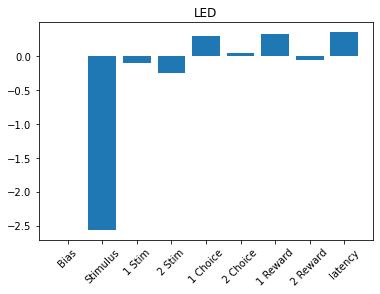

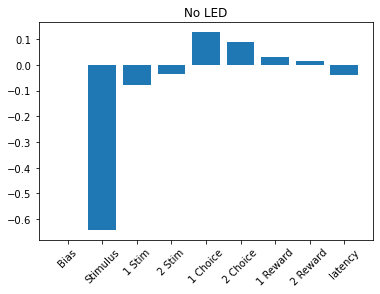

In [29]:
import matplotlib.pyplot as plt
x = np.arange(len(labels)) 

fig, ax = plt.subplots()
ax.bar(x, clf1.coef_[0])
plt.xticks(x,rotation = 45)
ax.set_xticklabels(labels)
plt.title('LED')

clf1.score(X1_test, y1_test)

fig, ax = plt.subplots()
ax.bar(x, clf2.coef_[0])
plt.xticks(x,rotation = 45)
ax.set_xticklabels(labels)
clf2.score(X2_test, y2_test)
plt.title('No LED')

# fig, ax = plt.subplots()
# ax.bar(x, clf3.coef_[0])
# plt.xticks(x,rotation = 45)
# ax.set_xticklabels(labels)
# clf3.score(X3_test, y3_test)
# plt.title('8 Hz')
# #  LED

0.8132201334141904

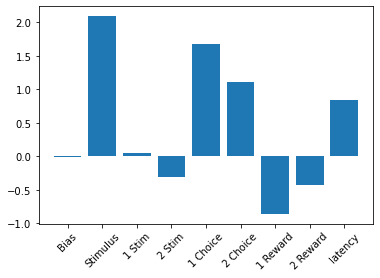

In [195]:
fig, ax = plt.subplots()
ax.bar(x, clf2.coef_[0])
plt.xticks(x,rotation = 45)
ax.set_xticklabels(labels)
clf2.score(X2_test, y2_test)
# no LED

0.7893462469733656

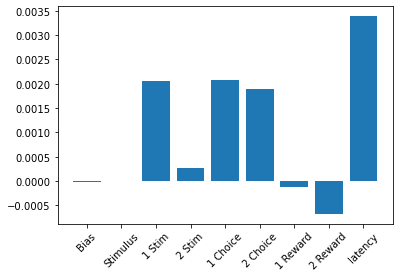

In [139]:
fig, ax = plt.subplots()
ax.bar(x, clf3.coef_[0])
plt.xticks(x,rotation = 45)
ax.set_xticklabels(labels)
clf3.score(X3_test, y3_test)

In [183]:
y_train

10799    0
8138     0
6116     1
4144     0
2569     1
        ..
4872     0
6478     0
7067     1
3239     1
8662     0
Name: Rightward, Length: 982, dtype: int64

In [387]:

import numpy as np
rw = np.array(b2['Rightward'])
np.sum(b2['Target'][b2['Stimulus'] > 0])


#b2.head()

14

To do list:
- decide on data input i.e. what stages of training to run analysis on
- write code to iteratively fit each animal by walking through the directories
- EVALUATE THE FITS - ensure the regression is actually fitting the data 

Tasks
- function to generate the inputs to the model
- function to split the data into groups of interest (i.e. LED, no LED, 8 Hz)
- function to run the model, generate score, return coefficients
- second function to run leave on out with each parameter with BIC to determine which weight is most important for the fit
- function to 

In [7]:
def generate_logistics_inputs(b2):
    import numpy as np

  
    previous_choice = expand_history(np.array(b2['Previous_rightward']), 1)
    previous_reward = expand_history(np.array(b2['Previous_correct']),1)
    previous_stimulus = expand_history(np.array(b2['Stimulus']),2)
    latency = np.array(b2['Latency'])

    X = np.c_[np.ones((latency.shape[0], 1)), previous_stimulus, previous_choice, previous_reward, latency]
    y = np.array(b2['Rightward'])
    
    select = np.array(b2)
    
    labels = ['Bias', 'Stimulus', '1 Stim', '2 Stim', '1 Choice', '2 Choice', '1 Reward', '2 Reward', 'latency']

    return X, y, labels

In [8]:
def split_data_inputs(X,y, b2):
    
    l = b2['LED'].astype(bool)
    s = b2['Stimulus'] != 0;
    rX = [X[~l&s ,:] , X[l&s ,:]]
   
    ry = [y[~l&s] , y[l&s ]]
    
    
    return rX, ry
    
    
    

In [9]:
def fit_logistic(X,y):
    #from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import KFold
    from sklearn.linear_model import LogisticRegression
    #rskf = StratifiedKFold(n_splits=5)
    rskf = KFold(n_splits=5, shuffle = True, random_state=50)
    #rskf.get_n_splits(X, y)

    score = []
    coef = []
    for train_index, test_index in rskf.split(X,y):
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        clf = LogisticRegression().fit(X_train, y_train)
        score.append(clf.score(X_test,y_test))
        coef.append(clf.coef_)
        
    return np.array(score), np.squeeze(np.array(coef))
    

In [10]:
def full_logistic_preprocess(path, animal):

    import os 
    b = load_beh_data(path, animal)

    filep = os.path.join(path,'analyze_training_'+animal+'.mat')
    m2 = import_matlab_file(filep)

    expert = m2['training']['days_expert']
    proficient = m2['training']['days_proficient']
    opto = m2['training']['days_opto']
    b = b[(b['sessionNum'] > expert) & (b['sessionNum'] >= proficient)]

    b2 = clean_beh_data(b)
    high_side = np.unique(b2['Target'][b2['Stimulus'] > 0]);

    X,y, labels = generate_logistics_inputs(b2)
    
    if high_side[0] == 0:
        y = (~(y.astype(bool))).astype(int)
        
    rX, ry = split_data_inputs(X,y,b2)
    
    
    
    
    scores,coefs = zip(*[fit_logistic(a,b) for a,b in zip(rX,ry)])
    
    
    
    return np.vstack(scores), np.dstack(coefs), labels




In [321]:
scores,coefs = zip(*[fit_logistic(a,b) for a,b in zip(rX,ry)])

c = np.dstack(coefs)
c.shape


(5, 9, 2)

In [322]:

xlist,ylist = zip(*[fit_logistic(a,b) for a,b in zip(rX,ry)])
ylist[0].shape

(5, 9)

GridSpec(1, 4)


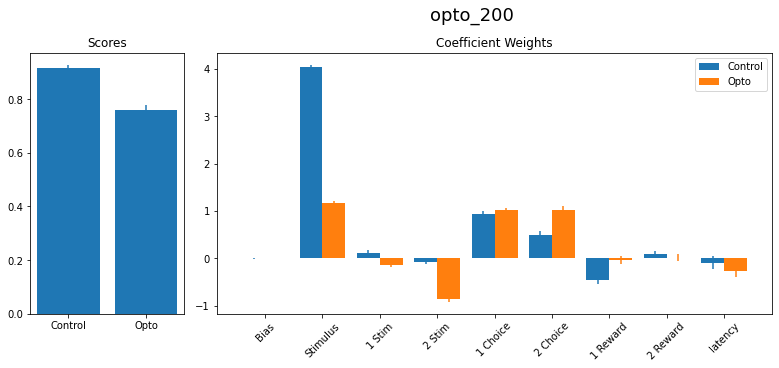

GridSpec(1, 4)


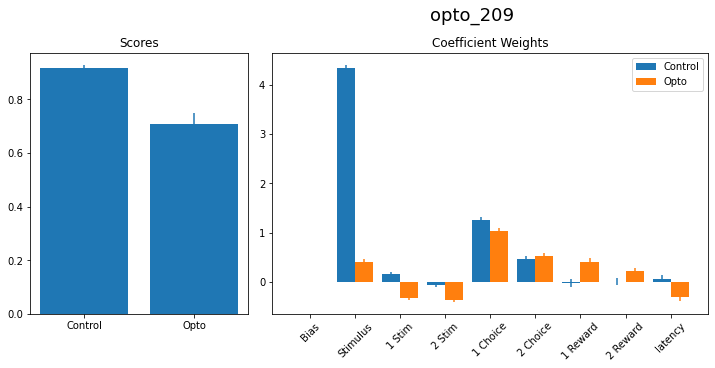

GridSpec(1, 4)


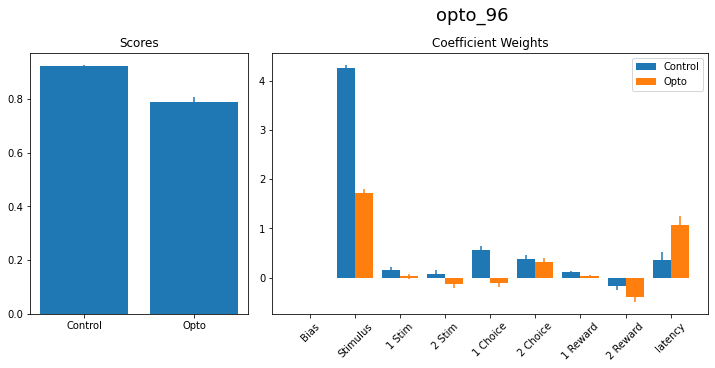

GridSpec(1, 4)


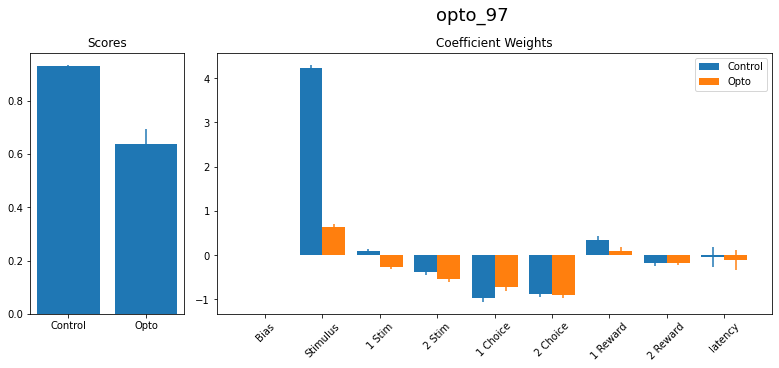

GridSpec(1, 4)


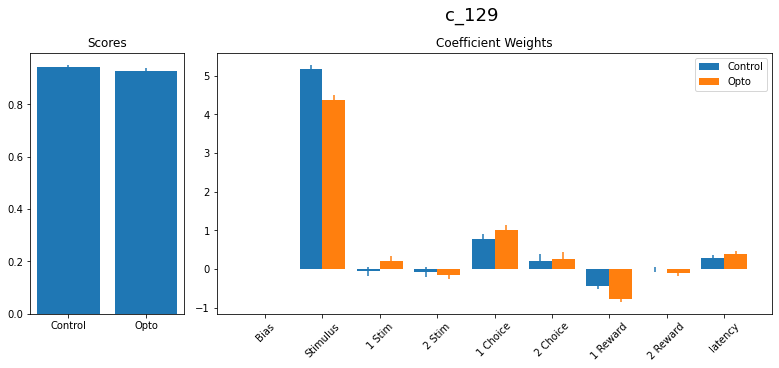

GridSpec(1, 4)


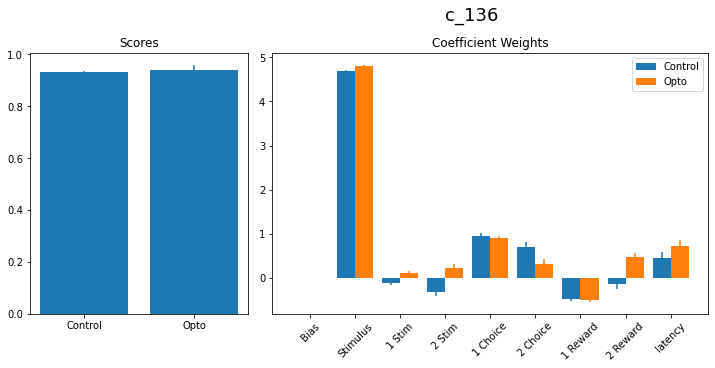

GridSpec(1, 4)


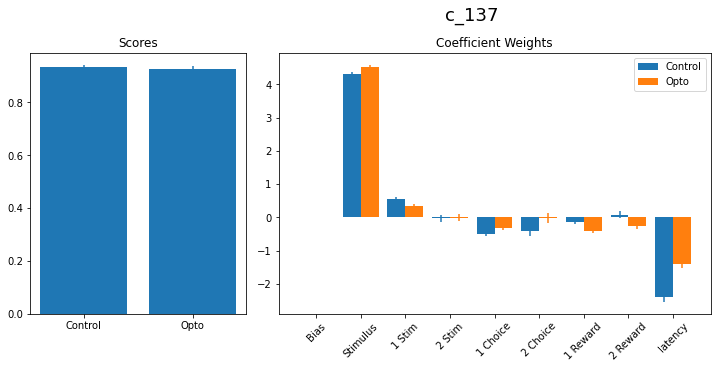

GridSpec(1, 4)


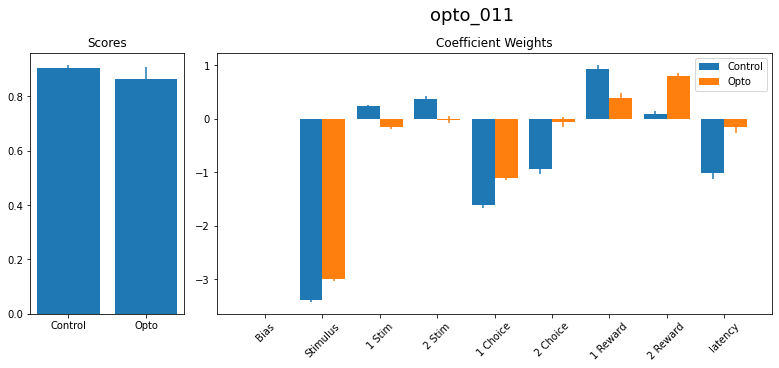

GridSpec(1, 4)


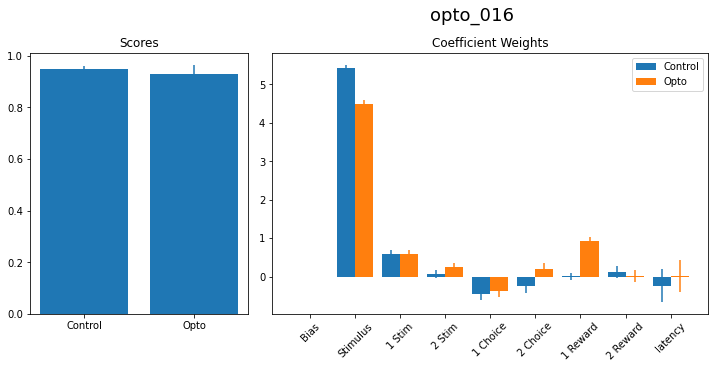

GridSpec(1, 4)


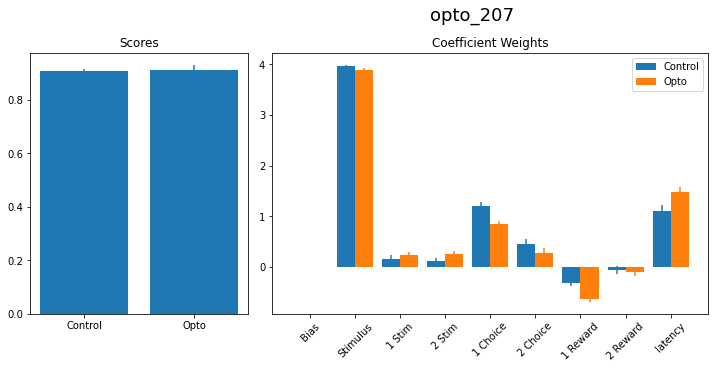

GridSpec(1, 4)


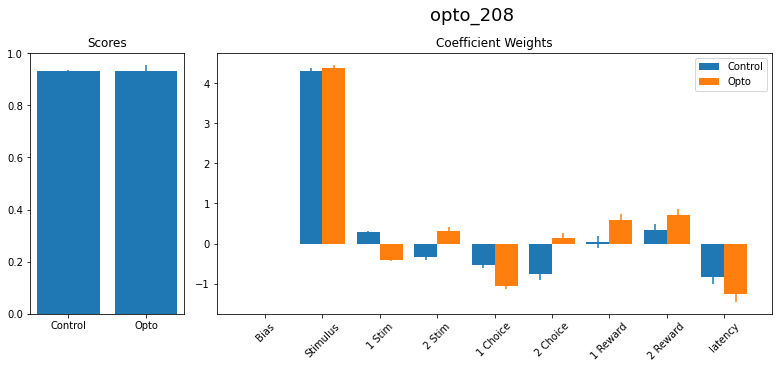

GridSpec(1, 4)


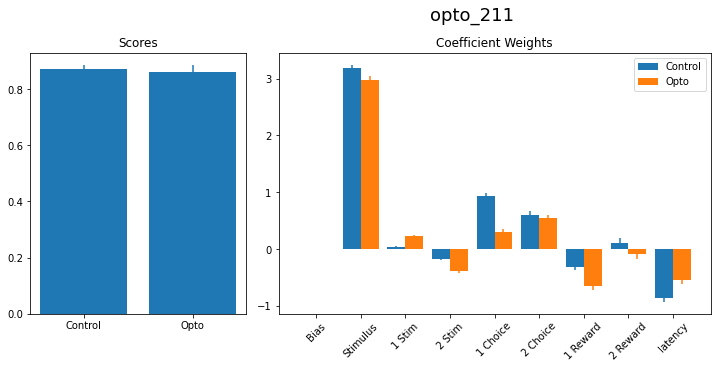

GridSpec(1, 4)


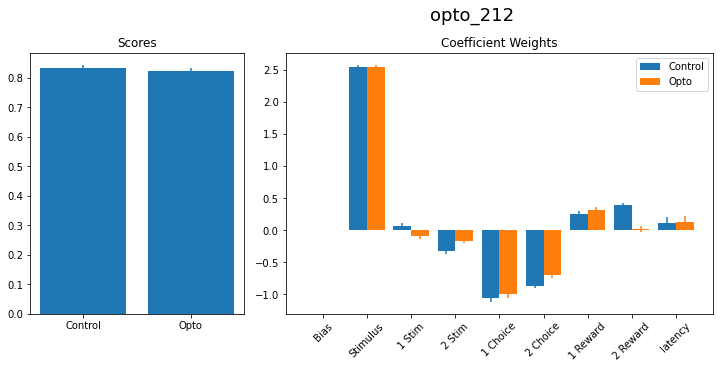

GridSpec(1, 4)


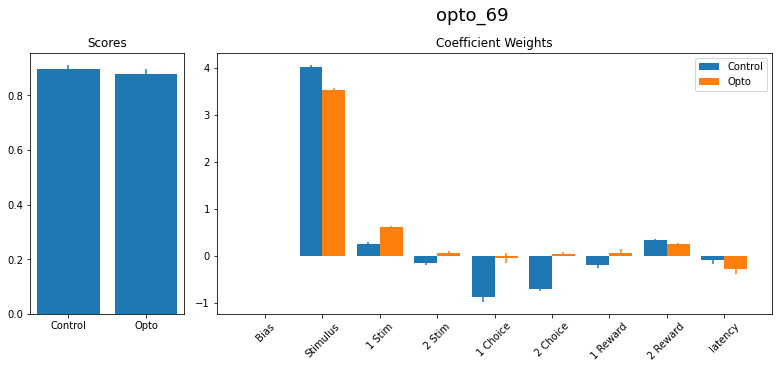

GridSpec(1, 4)


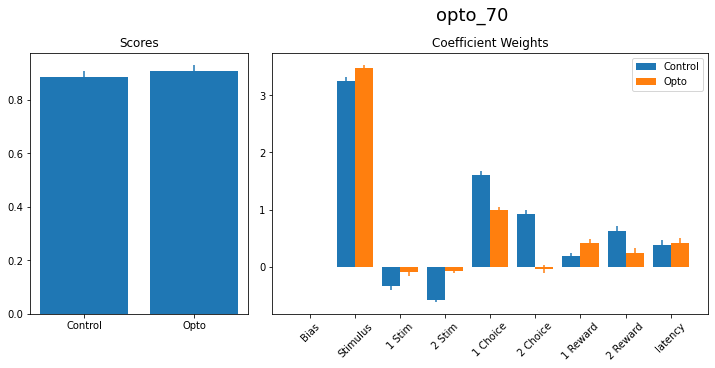

GridSpec(1, 4)


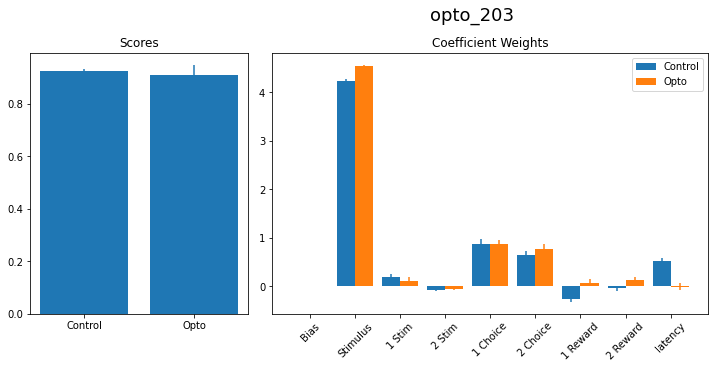

GridSpec(1, 4)


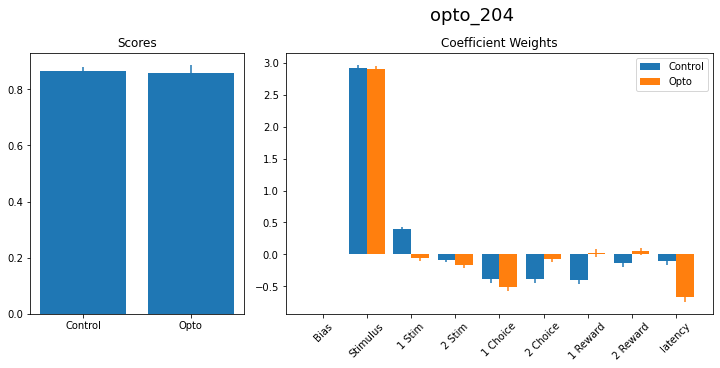

GridSpec(1, 4)


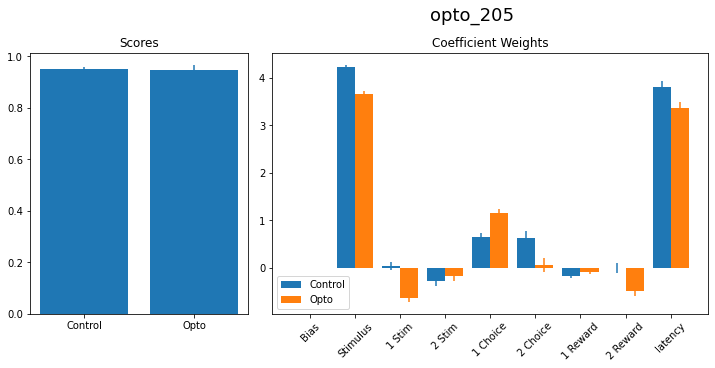

GridSpec(1, 4)


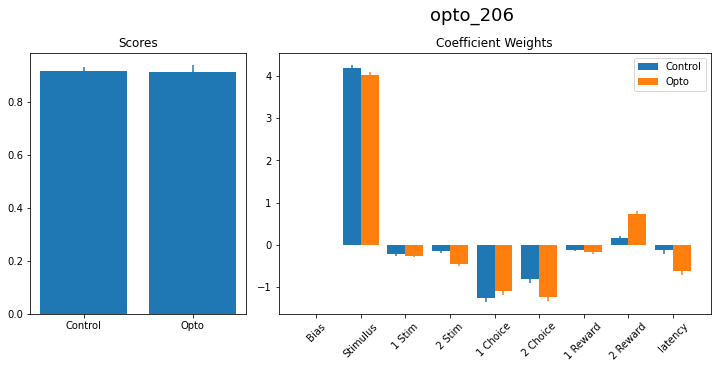

In [141]:
path = r"C:\Users\natet\Desktop\Experimental_Data"

import os
import numpy as np
experimental_groups = os.listdir(path)

for g in experimental_groups:
    
    g_dir = os.path.join(path,g)
    animals = os.listdir(g_dir)
    
    group_scores = []
    group_coefs = []
    
    for a in animals:
        a_dir = os.path.join(path,g,a)
        
        scores, coefs, labels = full_logistic_preprocess(a_dir, a)
        plot_single_logR(scores, coefs, a)
        group_coefs.append(np.mean(coefs, axis = 0))
        group_scores.append(np.mean(scores, axis = 1))
    
    gs = np.array(group_scores)
    gc = np.array(group_coefs)
    
    

                

In [305]:
experimental_groups = os.listdir(path)

for g in experimental_groups:
    g_dir = os.path.join(path,g)
    print(g_dir)
    print(os.listdir(os.path.join(path,g)))
    


C:\Users\natet\Desktop\Experimental_Data\CAMKII
['opto_200', 'opto_209', 'opto_96', 'opto_97']
C:\Users\natet\Desktop\Experimental_Data\Control
['c_129', 'c_136', 'c_137']
C:\Users\natet\Desktop\Experimental_Data\CT
['opto_011', 'opto_016', 'opto_207', 'opto_208']
C:\Users\natet\Desktop\Experimental_Data\ET
['opto_211', 'opto_212', 'opto_69', 'opto_70']
C:\Users\natet\Desktop\Experimental_Data\IT
['opto_203', 'opto_204', 'opto_205', 'opto_206']


In [347]:
import seaborn as sns

g = sns.catplot(
    data= coefs, kind="bar",
    x="species", y="body_mass_g", hue="sex",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")

AttributeError: 'numpy.ndarray' object has no attribute 'get'

In [140]:

def plot_single_logR(scores, coefs, a):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    %matplotlib inline

    fig = plt.figure(constrained_layout=True, figsize=(13,5))
    spec = gridspec.GridSpec(ncols=4, nrows=1, figure=fig)
    

    ax1 = fig.add_subplot(spec[0, 0])
    ax2 = fig.add_subplot(spec[0, 1:3])


    ax1.bar([1,2],np.mean(scores, axis = 1))

    ax1.errorbar([1,2],np.mean(scores, axis = 1), np.std(scores, axis = 1), ls = '')
    ax1.set_title('Scores')

    ax1.set_xticks([1,2])
    ax1.set_xticklabels(["Control", "Opto"])

    width = 0.40

    ax2.bar(np.arange(len(labels)) - width/2,np.squeeze(np.mean(coefs[:,:,0], axis = 0)), width, label = 'Control')
    ax2.errorbar(np.arange(len(labels)) - width/2,np.squeeze(np.mean(coefs[:,:,0], axis = 0)),np.squeeze(np.std(coefs[:,:,0], axis = 0)), ls = '')

    ax2.bar(np.arange(len(labels)) + width/2,np.squeeze(np.mean(coefs[:,:,1], axis = 0)), width, label = 'Opto')
    ax2.errorbar(np.arange(len(labels)) + width/2,np.squeeze(np.mean(coefs[:,:,1], axis = 0)),np.squeeze(np.std(coefs[:,:,0], axis = 0)), ls = '')

    ax2.set_title('Coefficient Weights')
    ax2.set_xticks(np.arange(len(labels)))
    ax2.set_xticklabels(labels)
    ax2.tick_params(axis='x', labelrotation = 45)
    # ax2.autoscale(tight=True)
    ax2.legend()

    # ax2.bar_label(nl, padding=3)
    # ax2.bar_label(l, padding=3)

    fig.suptitle(a, fontsize = 18)



    plt.show()




In [125]:
a

'opto_206'

In [17]:
tt

,0,1,2,3,4,5,6,7,8
0,-0.000121,4.236057,0.186240,-0.082194,0.880026,0.643652,-0.252564,-0.042541,0.523950
1,0.000088,2.919957,0.392204,-0.080625,-0.382891,-0.391934,-0.403562,-0.141185,-0.097531
2,0.000070,4.229858,0.040909,-0.275509,0.645517,0.626072,-0.174494,-0.003887,3.814210
3,-0.000136,4.181554,-0.226416,-0.152634,-1.262088,-0.815797,-0.111497,0.152522,-0.124241


In [420]:
(~(y.astype(bool))).astype(int)

107      0
117      0
119      0
121      0
122      0
        ..
11913    1
11914    0
11916    0
11918    0
11922    0
Name: Rightward, Length: 10476, dtype: int32